In [1]:
import os
from datetime import datetime, timedelta
from typing import TypedDict, Annotated, List, Literal
import operator
import json
import requests
import pandas as pd
from langchain_groq import ChatGroq
from langchain.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import openpyxl
from openpyxl.styles import Font, Alignment, PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows

In [2]:
from dotenv import load_dotenv
load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["OPENWEATHER_API_KEY"] = os.getenv("OPENWEATHER_API_KEY")
os.environ["EXCHANGERATE_API_KEY"] = os.getenv("EXCHANGERATE_API_KEY")

llm = ChatGroq(model="openai/gpt-oss-120b", temperature=0.7)

In [3]:
class TripPlannerState(MessagesState):
    # User inputs
    from_city: str
    to_city: str
    arrival_date: str
    num_days: int
    arrival_time: str
    num_adults: int
    num_kids: int
    
    # Tool outputs (stored as serializable dicts instead of DataFrames)
    weather_data: dict
    attractions_data: dict
    hotel_data: dict
    currency_info: str
    nearby_places_data: dict
    
    # Final outputs
    itinerary: str
    expenses_data: dict

In [4]:
@tool
def get_weather_info(city: str, date: str = None) -> str:
    """
    Get weather information for a city. 
    
    Args:
        city: Name of the city
        date: Date in YYYY-MM-DD format (optional)
    
    Returns:
        JSON string with weather information
    """
    try:
        api_key = os.environ.get("OPENWEATHER_API_KEY")
        
        if not api_key:
            return json.dumps({
                "error": "API key not configured",
                "message": "Please set OPENWEATHER_API_KEY"
            })
        
        # First, get coordinates for the city using geocoding API
        geo_url = "http://api.openweathermap.org/geo/1.0/direct"
        geo_params = {
            "q": city,
            "limit": 1,
            "appid": api_key
        }
        
        geo_response = requests.get(geo_url, params=geo_params, timeout=10)
        
        if geo_response.status_code != 200:
            return json.dumps({
                "error": "City not found",
                "city": city,
                "message": "Please check the city name"
            })
        
        geo_data = geo_response.json()
        if not geo_data:
            return json.dumps({
                "error": "City not found",
                "city": city,
                "message": "No results for this city name"
            })
        
        lat = geo_data[0]['lat']
        lon = geo_data[0]['lon']
        
        # Get weather forecast
        weather_url = "http://api.openweathermap.org/data/2.5/forecast"
        weather_params = {
            "lat": lat,
            "lon": lon,
            "appid": api_key,
            "units": "metric"
        }
        
        weather_response = requests.get(weather_url, params=weather_params, timeout=10)
        
        if weather_response.status_code == 200:
            data = weather_response.json()
            
            # Get forecasts for next 5 days
            forecasts = []
            seen_dates = set()
            
            for item in data['list'][:40]:  # 5 days * 8 (3-hour intervals)
                dt = datetime.fromtimestamp(item['dt'])
                date_str = dt.strftime('%Y-%m-%d')
                
                # Get one forecast per day (around noon)
                if date_str not in seen_dates and dt.hour in [12, 13, 14, 15]:
                    seen_dates.add(date_str)
                    forecasts.append({
                        "date": date_str,
                        "day": dt.strftime('%A'),
                        "temperature": round(item['main']['temp'], 1),
                        "feels_like": round(item['main']['feels_like'], 1),
                        "condition": item['weather'][0]['description'].title(),
                        "humidity": item['main']['humidity'],
                        "wind_speed": round(item['wind']['speed'], 1)
                    })
                
                if len(forecasts) == 5:
                    break
            
            return json.dumps({
                "city": city,
                "country": geo_data[0].get('country', 'Unknown'),
                "forecasts": forecasts
            })
        else:
            return json.dumps({
                "error": "Weather API error",
                "status_code": weather_response.status_code,
                "message": weather_response.text
            })
            
    except requests.exceptions.Timeout:
        return json.dumps({
            "error": "Request timeout",
            "message": "Weather service is taking too long to respond"
        })
    except requests.exceptions.RequestException as e:
        return json.dumps({
            "error": "Network error",
            "message": str(e)
        })
    except Exception as e:
        return json.dumps({
            "error": "Unexpected error",
            "message": str(e)
        })

# Test the weather tool
print("Testing weather tool...")
test_result = get_weather_info.invoke({"city": "Paris"})
print(test_result)

Testing weather tool...
{"city": "Paris", "country": "FR", "forecasts": [{"date": "2025-11-02", "day": "Sunday", "temperature": 12.2, "feels_like": 11.3, "condition": "Broken Clouds", "humidity": 70, "wind_speed": 4.4}, {"date": "2025-11-03", "day": "Monday", "temperature": 12.1, "feels_like": 11.4, "condition": "Broken Clouds", "humidity": 79, "wind_speed": 4.1}, {"date": "2025-11-04", "day": "Tuesday", "temperature": 11.7, "feels_like": 10.4, "condition": "Overcast Clouds", "humidity": 55, "wind_speed": 3.9}, {"date": "2025-11-05", "day": "Wednesday", "temperature": 14.6, "feels_like": 13.6, "condition": "Overcast Clouds", "humidity": 56, "wind_speed": 3.2}, {"date": "2025-11-06", "day": "Thursday", "temperature": 16.0, "feels_like": 15.5, "condition": "Overcast Clouds", "humidity": 72, "wind_speed": 4.5}]}


In [5]:
@tool
def get_top_attractions(city: str, num_days: int = 3) -> str:
    """
    Get top attractions for a city with estimated prices and details.
    
    Args:
        city: Name of the city
        num_days: Number of days for the trip
    
    Returns:
        JSON string with attractions data
    """
    prompt = f"""List the top {min(num_days * 3, 10)} attractions in {city}.

For each attraction, provide:
- name: Attraction name
- description: Brief description (1 sentence)
- category: Type (Museum, Park, Monument, etc.)
- ticket_price: Estimated ticket price in local currency (number only, if free put 0)
- currency: Currency code (USD, EUR, INR, etc.)
- duration: Recommended visit time (e.g., "2 hours", "Half day")
- rating: Tourist rating out of 5

Return ONLY a valid JSON array with these exact fields. Example format:
[
  {{"name": "Eiffel Tower", "description": "Iconic iron tower", "category": "Monument", "ticket_price": 26, "currency": "EUR", "duration": "2-3 hours", "rating": 4.8}},
  {{"name": "Louvre Museum", "description": "World's largest art museum", "category": "Museum", "ticket_price": 17, "currency": "EUR", "duration": "Half day", "rating": 4.7}}
]
"""
    
    try:
        response = llm.invoke(prompt)
        content = response.content
        
        # Extract JSON from response
        import re
        json_match = re.search(r'\[.*\]', content, re.DOTALL)
        
        if json_match:
            return json_match.group()
        else:
            # Fallback
            return json.dumps([{
                "name": f"Popular Attraction in {city}",
                "description": "Major tourist destination",
                "category": "General",
                "ticket_price": 20,
                "currency": "USD",
                "duration": "2 hours",
                "rating": 4.5
            }])
    except Exception as e:
        return json.dumps([{"error": str(e)}])

In [6]:
@tool
def get_hotel_recommendations(city: str, num_adults: int, num_kids: int, num_days: int) -> str:
    """
    Get hotel recommendations with prices and ratings.
    
    Args:
        city: Name of the city
        num_adults: Number of adults
        num_kids: Number of children
        num_days: Number of nights
    
    Returns:
        JSON string with hotel data
    """
    prompt = f"""Suggest 5 hotels in {city} for {num_adults} adults and {num_kids} kids for {num_days} nights.

For each hotel, provide:
- name: Hotel name
- star_rating: Stars (3, 4, or 5)
- price_per_night: Price per night in local currency (number only)
- currency: Currency code
- guest_rating: Guest rating out of 10 (e.g., 8.5)
- amenities: List of 3-4 key amenities as array
- location: Area/neighborhood name
- total_price: Total for {num_days} nights (price_per_night * num_days)

Include budget (3-star), mid-range (4-star), and luxury (5-star) options.

Return ONLY a valid JSON array. Example:
[
  {{"name": "Hotel Paris", "star_rating": 4, "price_per_night": 150, "currency": "EUR", "guest_rating": 8.5, "amenities": ["WiFi", "Breakfast", "Gym"], "location": "City Center", "total_price": 750}}
]
"""
    
    try:
        response = llm.invoke(prompt)
        content = response.content
        
        import re
        json_match = re.search(r'\[.*\]', content, re.DOTALL)
        
        if json_match:
            return json_match.group()
        else:
            return json.dumps([{
                "name": f"Hotel in {city}",
                "star_rating": 4,
                "price_per_night": 100,
                "currency": "USD",
                "guest_rating": 8.0,
                "amenities": ["WiFi", "Breakfast"],
                "location": "City Center",
                "total_price": 100 * num_days
            }])
    except Exception as e:
        return json.dumps([{"error": str(e)}])

In [7]:
@tool
def convert_currency(from_city: str, to_city: str) -> str:
    """
    Get currency conversion information between two cities.
    
    Args:
        from_city: Origin city
        to_city: Destination city
    
    Returns:
        JSON string with conversion info
    """
    # Expanded city to currency mapping
    city_to_currency = {
        # US Cities
        "new york": "USD", "los angeles": "USD", "chicago": "USD", "san francisco": "USD",
        "miami": "USD", "boston": "USD", "seattle": "USD", "las vegas": "USD",
        
        # UK Cities
        "london": "GBP", "manchester": "GBP", "edinburgh": "GBP", "liverpool": "GBP",
        
        # Europe
        "paris": "EUR", "berlin": "EUR", "rome": "EUR", "madrid": "EUR",
        "barcelona": "EUR", "amsterdam": "EUR", "vienna": "EUR", "prague": "CZK",
        "zurich": "CHF", "stockholm": "SEK", "copenhagen": "DKK",
        
        # Asia
        "tokyo": "JPY", "osaka": "JPY", "kyoto": "JPY",
        "mumbai": "INR", "delhi": "INR", "bangalore": "INR", "kolkata": "INR",
        "chennai": "INR", "hyderabad": "INR", "pune": "INR",
        "singapore": "SGD", "hong kong": "HKD", "bangkok": "THB",
        "dubai": "AED", "abu dhabi": "AED",
        "beijing": "CNY", "shanghai": "CNY",
        "seoul": "KRW",
        
        # Oceania
        "sydney": "AUD", "melbourne": "AUD", "auckland": "NZD",
        
        # Others
        "toronto": "CAD", "vancouver": "CAD", "montreal": "CAD",
        "mexico city": "MXN",
        "sao paulo": "BRL", "rio de janeiro": "BRL",
    }
    
    from_curr = city_to_currency.get(from_city.lower(), "USD")
    to_curr = city_to_currency.get(to_city.lower(), "USD")
    
    if from_curr == to_curr:
        return json.dumps({
            "from_city": from_city,
            "to_city": to_city,
            "from_currency": from_curr,
            "to_currency": to_curr,
            "exchange_rate": 1.0,
            "message": f"Both cities use {from_curr}. No conversion needed."
        })
    
    try:
        # Using exchangerate-api.com (free tier available)
        url = f"https://api.exchangerate-api.com/v4/latest/{from_curr}"
        
        response = requests.get(url, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            rate = data['rates'].get(to_curr, 1.0)
            
            return json.dumps({
                "from_city": from_city,
                "to_city": to_city,
                "from_currency": from_curr,
                "to_currency": to_curr,
                "exchange_rate": round(rate, 4),
                "message": f"1 {from_curr} = {rate:.4f} {to_curr}",
                "last_updated": data.get('date', 'Unknown')
            })
        else:
            return json.dumps({
                "from_city": from_city,
                "to_city": to_city,
                "from_currency": from_curr,
                "to_currency": to_curr,
                "exchange_rate": 1.0,
                "message": "Exchange rate API unavailable"
            })
            
    except Exception as e:
        return json.dumps({
            "from_city": from_city,
            "to_city": to_city,
            "from_currency": from_curr,
            "to_currency": to_curr,
            "exchange_rate": 1.0,
            "error": str(e)
        })

In [8]:
@tool
def get_nearby_places(city: str) -> str:
    """
    Get nearby cities/places worth visiting from the given city.
    
    Args:
        city: Name of the city
    
    Returns:
        JSON string with nearby places
    """
    prompt = f"""List 6 cities or places near {city} that are worth visiting.

For each place, provide:
- name: Place name
- distance_km: Distance from {city} in kilometers (number only)
- transport: Best transport mode (Train, Bus, Flight, Car)
- famous_for: What it's known for (1 short phrase)
- recommended_duration: How long to stay (e.g., "1 day", "2-3 days")
- estimated_cost: Estimated cost for the visit in local currency (number only)

Return ONLY a valid JSON array. Example:
[
  {{"name": "Versailles", "distance_km": 20, "transport": "Train", "famous_for": "Palace and Gardens", "recommended_duration": "1 day", "estimated_cost": 50}}
]
"""
    
    try:
        response = llm.invoke(prompt)
        content = response.content
        
        import re
        json_match = re.search(r'\[.*\]', content, re.DOTALL)
        
        if json_match:
            return json_match.group()
        else:
            return json.dumps([{
                "name": f"Near {city}",
                "distance_km": 50,
                "transport": "Train",
                "famous_for": "Tourist destination",
                "recommended_duration": "1 day",
                "estimated_cost": 50
            }])
    except Exception as e:
        return json.dumps([{"error": str(e)}])

In [9]:
# Create tool list
tools = [
    get_weather_info,
    get_top_attractions,
    get_hotel_recommendations,
    convert_currency,
    get_nearby_places
]

# Bind tools to LLM
llm_with_tools = llm.bind_tools(tools)

print("✅ Tools bound to LLM successfully!")
print(f"Available tools: {[tool.name for tool in tools]}")

✅ Tools bound to LLM successfully!
Available tools: ['get_weather_info', 'get_top_attractions', 'get_hotel_recommendations', 'convert_currency', 'get_nearby_places']


In [10]:
def agent_node(state: TripPlannerState):
    """
    Agent node that decides which tools to call based on user input
    """
    messages = state["messages"]
    
    # Call LLM with tools
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}

In [11]:
def should_continue(state: TripPlannerState) -> Literal["tools", "process_results"]:
    """
    Determine if we should use tools or process results
    """
    messages = state["messages"]
    last_message = messages[-1]
    
    # If LLM makes tool calls, route to tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, process results
    return "process_results"

In [12]:
def process_results_node(state: TripPlannerState):
    """
    Process tool outputs into structured dictionaries (serializable)
    """
    messages = state["messages"]
    
    # Extract tool results from messages
    weather_data = None
    attractions_data = None
    hotels_data = None
    currency_data = None
    nearby_data = None
    
    for msg in messages:
        if isinstance(msg, ToolMessage):
            try:
                content = json.loads(msg.content)
                
                # Check which tool this is from
                if "forecasts" in content:  # Weather tool
                    weather_data = content
                elif isinstance(content, list) and len(content) > 0:
                    if "ticket_price" in content[0]:  # Attractions
                        attractions_data = {"items": content}
                    elif "star_rating" in content[0]:  # Hotels
                        hotels_data = {"items": content}
                    elif "distance_km" in content[0]:  # Nearby places
                        nearby_data = {"items": content}
                elif "exchange_rate" in content:  # Currency
                    currency_data = content
            except:
                continue
    
    # Format currency string
    currency_str = ""
    if currency_data:
        currency_str = f"""Currency Conversion:
From: {currency_data.get('from_currency', 'N/A')} ({currency_data.get('from_city', 'N/A')})
To: {currency_data.get('to_currency', 'N/A')} ({currency_data.get('to_city', 'N/A')})
Exchange Rate: 1 {currency_data.get('from_currency', '')} = {currency_data.get('exchange_rate', 0)} {currency_data.get('to_currency', '')}
{currency_data.get('message', '')}"""
    
    return {
        "weather_data": weather_data or {},
        "attractions_data": attractions_data or {},
        "hotel_data": hotels_data or {},
        "currency_info": currency_str,
        "nearby_places_data": nearby_data or {}
    }

In [13]:
def create_itinerary_node(state: TripPlannerState):
    """
    Create comprehensive itinerary using all collected data
    """
    # Convert data to DataFrames for display
    weather_df = None
    if state.get("weather_data") and "forecasts" in state["weather_data"]:
        weather_df = pd.DataFrame(state["weather_data"]["forecasts"])
        weather_text = weather_df.to_string(index=False)
    else:
        weather_text = "No weather data available"
    
    attractions_df = None
    if state.get("attractions_data") and "items" in state["attractions_data"]:
        attractions_df = pd.DataFrame(state["attractions_data"]["items"])
        attractions_text = attractions_df.to_string(index=False)
    else:
        attractions_text = "No attractions data available"
    
    hotel_df = None
    if state.get("hotel_data") and "items" in state["hotel_data"]:
        hotel_df = pd.DataFrame(state["hotel_data"]["items"])
        hotels_text = hotel_df.to_string(index=False)
    else:
        hotels_text = "No hotel data available"
    
    nearby_df = None
    if state.get("nearby_places_data") and "items" in state["nearby_places_data"]:
        nearby_df = pd.DataFrame(state["nearby_places_data"]["items"])
        nearby_text = nearby_df.to_string(index=False)
    else:
        nearby_text = "No nearby places data available"
    
    prompt = f"""Create a comprehensive, well-formatted travel itinerary based on this information:

TRIP DETAILS:
- From: {state['from_city']}
- To: {state['to_city']}
- Arrival: {state['arrival_date']} at {state['arrival_time']}
- Duration: {state['num_days']} days
- Travelers: {state['num_adults']} adults, {state['num_kids']} children

WEATHER FORECAST:
{weather_text}

TOP ATTRACTIONS:
{attractions_text}

HOTEL OPTIONS:
{hotels_text}

CURRENCY INFO:
{state.get('currency_info', 'No currency info')}

NEARBY PLACES:
{nearby_text}

Create a detailed day-by-day itinerary that includes:
1. Daily schedule with morning, afternoon, and evening activities
2. Recommended hotel from the list with justification
3. Meal suggestions for each day
4. Transportation tips
5. Packing recommendations based on weather
6. Important travel tips and local customs
7. Best time to visit each attraction to avoid crowds

Make it engaging, practical, and family-friendly (considering {state['num_kids']} children).
Format it clearly with headers and bullet points."""
    
    try:
        response = llm.invoke(prompt)
        return {"itinerary": response.content}
    except Exception as e:
        return {"itinerary": f"Error creating itinerary: {str(e)}"}

In [14]:
def calculate_expenses_node(state: TripPlannerState):
    """
    Calculate total expenses and store as dictionary
    """
    num_days = state.get("num_days", 3)
    num_adults = state.get("num_adults", 2)
    num_kids = state.get("num_kids", 0)
    
    expenses = []
    currency = "USD"
    
    # Accommodation
    if state.get("hotel_data") and "items" in state["hotel_data"]:
        hotels = state["hotel_data"]["items"]
        if len(hotels) > 0:
            # Pick mid-range hotel (3rd option if available)
            hotel_idx = min(2, len(hotels) - 1)
            hotel = hotels[hotel_idx]
            hotel_price = hotel.get('total_price', 150 * num_days)
            currency = hotel.get('currency', 'USD')
            expenses.append({
                "category": "Accommodation",
                "description": f"{hotel.get('name', 'Hotel')} - {num_days} nights",
                "amount": hotel_price,
                "currency": currency
            })
    
    if not expenses:  # Fallback
        expenses.append({
            "category": "Accommodation",
            "description": f"Estimated hotel - {num_days} nights",
            "amount": 150 * num_days,
            "currency": currency
        })
    
    # Attractions
    if state.get("attractions_data") and "items" in state["attractions_data"]:
        attractions = state["attractions_data"]["items"]
        total_attractions = sum([a.get('ticket_price', 0) for a in attractions]) * (num_adults + num_kids * 0.5)
        if len(attractions) > 0:
            currency = attractions[0].get('currency', currency)
        expenses.append({
            "category": "Attractions & Activities",
            "description": f"Entry tickets for {len(attractions)} attractions",
            "amount": round(total_attractions, 2),
            "currency": currency
        })
    else:
        expenses.append({
            "category": "Attractions & Activities",
            "description": "Estimated attraction costs",
            "amount": 200,
            "currency": currency
        })
    
    # Food
    food_per_person_per_day = 50
    total_people = num_adults + num_kids
    food_cost = food_per_person_per_day * total_people * num_days
    expenses.append({
        "category": "Food & Dining",
        "description": f"{total_people} people × {num_days} days",
        "amount": food_cost,
        "currency": currency
    })
    
    # Local Transportation
    transport_cost = 30 * num_days
    expenses.append({
        "category": "Local Transportation",
        "description": f"Metro, taxis, local travel - {num_days} days",
        "amount": transport_cost,
        "currency": currency
    })
    
    # Miscellaneous
    total_so_far = sum([e['amount'] for e in expenses])
    misc_cost = round(total_so_far * 0.1, 2)
    expenses.append({
        "category": "Miscellaneous",
        "description": "Souvenirs, tips, emergencies (10%)",
        "amount": misc_cost,
        "currency": currency
    })
    
    # Calculate total
    total_amount = round(sum([e['amount'] for e in expenses]), 2)
    
    # Add total
    expenses.append({
        "category": "TOTAL",
        "description": "Total estimated expenses",
        "amount": total_amount,
        "currency": currency
    })
    
    return {"expenses_data": {"items": expenses, "currency": currency, "total": total_amount}}

In [15]:
# Create the graph
workflow = StateGraph(TripPlannerState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", ToolNode(tools))
workflow.add_node("process_results", process_results_node)
workflow.add_node("create_itinerary", create_itinerary_node)
workflow.add_node("calculate_expenses", calculate_expenses_node)

# Set entry point
workflow.set_entry_point("agent")

# Add conditional edges
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "process_results": "process_results"
    }
)

# After tools, go back to agent
workflow.add_edge("tools", "agent")

# After processing results, create itinerary
workflow.add_edge("process_results", "create_itinerary")

# After itinerary, calculate expenses
workflow.add_edge("create_itinerary", "calculate_expenses")

# End after expenses
workflow.add_edge("calculate_expenses", END)

# Compile
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("✅ LangGraph workflow created successfully!")

✅ LangGraph workflow created successfully!


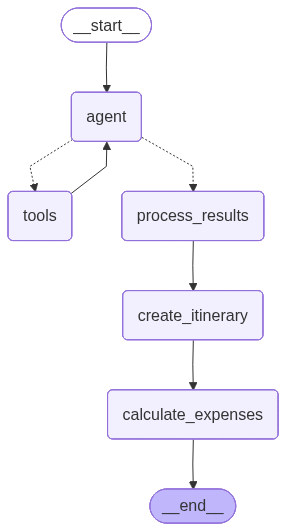

In [16]:
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [33]:
def export_to_excel(state, filename: str = "trip_plan.xlsx"):
    """
    Export all data to a comprehensive Excel file
    """
    wb = openpyxl.Workbook()
    
    # Remove default sheet
    if 'Sheet' in wb.sheetnames:
        wb.remove(wb['Sheet'])
    
    # Trip Summary Sheet
    ws_summary = wb.create_sheet("Trip Summary")
    ws_summary['A1'] = f"Trip Plan: {state.get('from_city', 'N/A')} → {state.get('to_city', 'N/A')}"
    ws_summary['A1'].font = Font(size=16, bold=True)
    ws_summary.merge_cells('A1:D1')
    
    summary_data = [
        ["From", state.get('from_city', 'N/A')],
        ["To", state.get('to_city', 'N/A')],
        ["Arrival Date", state.get('arrival_date', 'N/A')],
        ["Arrival Time", state.get('arrival_time', 'N/A')],
        ["Duration", f"{state.get('num_days', 0)} days"],
        ["Travelers", f"{state.get('num_adults', 0)} adults, {state.get('num_kids', 0)} children"]
    ]
    
    for idx, row in enumerate(summary_data, start=3):
        ws_summary[f'A{idx}'] = row[0]
        ws_summary[f'B{idx}'] = row[1]
        ws_summary[f'A{idx}'].font = Font(bold=True)
    
    # Set column widths for summary
    ws_summary.column_dimensions['A'].width = 20
    ws_summary.column_dimensions['B'].width = 30
    
    # Weather Sheet
    if state.get("weather_data") and "forecasts" in state["weather_data"]:
        weather_df = pd.DataFrame(state["weather_data"]["forecasts"])
        ws_weather = wb.create_sheet("Weather Forecast")
        for r_idx, row in enumerate(dataframe_to_rows(weather_df, index=False, header=True), 1):
            for c_idx, value in enumerate(row, 1):
                cell = ws_weather.cell(row=r_idx, column=c_idx, value=value)
                if r_idx == 1:
                    cell.font = Font(bold=True)
                    cell.fill = PatternFill(start_color="CCCCCC", end_color="CCCCCC", fill_type="solid")
        
        # Adjust column widths
        for col in ws_weather.columns:
            max_length = 0
            column = col[0].column_letter
            for cell in col:
                try:
                    if cell.value and len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = min(max_length + 2, 30)
            ws_weather.column_dimensions[column].width = adjusted_width
    
    # Attractions Sheet
    if state.get("attractions_data") and "items" in state["attractions_data"]:
        attractions_df = pd.DataFrame(state["attractions_data"]["items"])
        ws_attr = wb.create_sheet("Attractions")
        for r_idx, row in enumerate(dataframe_to_rows(attractions_df, index=False, header=True), 1):
            for c_idx, value in enumerate(row, 1):
                cell = ws_attr.cell(row=r_idx, column=c_idx, value=value)
                if r_idx == 1:
                    cell.font = Font(bold=True)
                    cell.fill = PatternFill(start_color="CCCCCC", end_color="CCCCCC", fill_type="solid")
        
        # Adjust column widths
        for col_letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
            ws_attr.column_dimensions[col_letter].width = 20
    
    # Hotels Sheet
    if state.get("hotel_data") and "items" in state["hotel_data"]:
        hotels_df = pd.DataFrame(state["hotel_data"]["items"])
        ws_hotel = wb.create_sheet("Hotels")
        for r_idx, row in enumerate(dataframe_to_rows(hotels_df, index=False, header=True), 1):
            for c_idx, value in enumerate(row, 1):
                # Convert lists to strings for Excel
                if isinstance(value, list):
                    value = ', '.join(str(v) for v in value)
                cell = ws_hotel.cell(row=r_idx, column=c_idx, value=value)
                if r_idx == 1:
                    cell.font = Font(bold=True)
                    cell.fill = PatternFill(start_color="CCCCCC", end_color="CCCCCC", fill_type="solid")
        
        # Adjust column widths
        for col_letter in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
            ws_hotel.column_dimensions[col_letter].width = 20
    
    # Nearby Places Sheet
    if state.get("nearby_places_data") and "items" in state["nearby_places_data"]:
        nearby_df = pd.DataFrame(state["nearby_places_data"]["items"])
        ws_nearby = wb.create_sheet("Nearby Places")
        for r_idx, row in enumerate(dataframe_to_rows(nearby_df, index=False, header=True), 1):
            for c_idx, value in enumerate(row, 1):
                cell = ws_nearby.cell(row=r_idx, column=c_idx, value=value)
                if r_idx == 1:
                    cell.font = Font(bold=True)
                    cell.fill = PatternFill(start_color="CCCCCC", end_color="CCCCCC", fill_type="solid")
        
        # Adjust column widths
        for col_letter in ['A', 'B', 'C', 'D', 'E', 'F']:
            ws_nearby.column_dimensions[col_letter].width = 20
    
    # Expenses Sheet
    if state.get("expenses_data") and "items" in state["expenses_data"]:
        expenses_df = pd.DataFrame(state["expenses_data"]["items"])
        ws_expense = wb.create_sheet("Expenses")
        for r_idx, row in enumerate(dataframe_to_rows(expenses_df, index=False, header=True), 1):
            for c_idx, value in enumerate(row, 1):
                cell = ws_expense.cell(row=r_idx, column=c_idx, value=value)
                if r_idx == 1:
                    cell.font = Font(bold=True)
                    cell.fill = PatternFill(start_color="CCCCCC", end_color="CCCCCC", fill_type="solid")
                # Highlight total row
                if isinstance(value, str) and value == "TOTAL":
                    for col in range(1, 5):
                        ws_expense.cell(row=r_idx, column=col).font = Font(bold=True, size=12)
                        ws_expense.cell(row=r_idx, column=col).fill = PatternFill(
                            start_color="FFFF00", end_color="FFFF00", fill_type="solid"
                        )
        
        # Adjust column widths
        ws_expense.column_dimensions['A'].width = 25
        ws_expense.column_dimensions['B'].width = 40
        ws_expense.column_dimensions['C'].width = 15
        ws_expense.column_dimensions['D'].width = 15
    
    # Itinerary Sheet
    ws_itinerary = wb.create_sheet("Complete Itinerary")
    ws_itinerary['A1'] = "Detailed Itinerary"
    ws_itinerary['A1'].font = Font(size=14, bold=True)
    
    itinerary_text = state.get("itinerary", "No itinerary generated")
    lines = itinerary_text.split('\n')
    for idx, line in enumerate(lines, start=3):
        ws_itinerary[f'A{idx}'] = line
        ws_itinerary.row_dimensions[idx].height = 15
    
    # Set column width for itinerary
    ws_itinerary.column_dimensions['A'].width = 100
    
    wb.save(filename)
    return filename

In [18]:
def plan_trip(from_city: str, to_city: str, arrival_date: str, 
              num_days: int = 3, arrival_time: str = "10:00 AM",
              num_adults: int = 2, num_kids: int = 0):
    """
    Main function to plan a complete trip
    """
    
    # Create initial message for the agent
    initial_message = f"""I need help planning a trip with the following details:

From: {from_city}
To: {to_city}
Arrival Date: {arrival_date}
Arrival Time: {arrival_time}
Duration: {num_days} days
Travelers: {num_adults} adults and {num_kids} children

Please help me by:
1. Getting the weather forecast for {to_city}
2. Finding top attractions in {to_city}
3. Recommending hotels for {num_adults} adults and {num_kids} kids for {num_days} nights
4. Converting currency from {from_city} to {to_city}
5. Suggesting nearby places to visit from {to_city}

Use all available tools to gather this information."""
    
    # Initialize state
    initial_state = {
        "messages": [HumanMessage(content=initial_message)],
        "from_city": from_city,
        "to_city": to_city,
        "arrival_date": arrival_date,
        "num_days": num_days,
        "arrival_time": arrival_time,
        "num_adults": num_adults,
        "num_kids": num_kids,
        "weather_data": {},
        "attractions_data": {},
        "hotel_data": {},
        "currency_info": "",
        "nearby_places_data": {},
        "itinerary": "",
        "expenses_data": {}
    }
    
    config = {"configurable": {"thread_id": "trip_planning_session"}}
    
    print(f"\n{'='*80}")
    print(f"🚀 Starting AI Trip Planner")
    print(f"{'='*80}\n")
    print(f"📍 From: {from_city}")
    print(f"📍 To: {to_city}")
    print(f"📅 Date: {arrival_date} at {arrival_time}")
    print(f"⏱️  Duration: {num_days} days")
    print(f"👥 Travelers: {num_adults} adults, {num_kids} children\n")
    print(f"{'='*80}\n")
    
    # Run the workflow
    print("🔄 Running AI agent with tools...\n")
    
    final_state = None
    step_count = 0
    for output in app.stream(initial_state, config):
        step_count += 1
        node_name = list(output.keys())[0]
        print(f"Step {step_count}: Executing '{node_name}' node...")
        # Keep updating final_state with each output
        if final_state is None:
            final_state = output[node_name]
        else:
            # Merge the updates into final_state
            final_state.update(output[node_name])
    
    print(f"\n{'='*80}")
    print("✅ Trip planning completed!")
    print(f"{'='*80}\n")
    
    return final_state

In [19]:
# Example usage
result = plan_trip(
    from_city="Mumbai",
    to_city="Paris",
    arrival_date="2025-12-15",
    num_days=2,
    arrival_time="2:00 PM",
    num_adults=2,
    num_kids=1
)


🚀 Starting AI Trip Planner

📍 From: Mumbai
📍 To: Paris
📅 Date: 2025-12-15 at 2:00 PM
⏱️  Duration: 2 days
👥 Travelers: 2 adults, 1 children


🔄 Running AI agent with tools...

Step 1: Executing 'agent' node...
Step 2: Executing 'tools' node...
Step 3: Executing 'agent' node...
Step 4: Executing 'tools' node...
Step 5: Executing 'agent' node...
Step 6: Executing 'tools' node...
Step 7: Executing 'agent' node...
Step 8: Executing 'tools' node...
Step 9: Executing 'agent' node...
Step 10: Executing 'tools' node...
Step 11: Executing 'agent' node...
Step 12: Executing 'tools' node...
Step 13: Executing 'agent' node...
Step 14: Executing 'process_results' node...
Step 15: Executing 'create_itinerary' node...
Step 16: Executing 'calculate_expenses' node...

✅ Trip planning completed!



In [20]:
print("\n" + "="*80)
print("🌤️  WEATHER FORECAST")
print("="*80 + "\n")

if result.get("weather_data") and "forecasts" in result["weather_data"]:
    weather_df = pd.DataFrame(result["weather_data"]["forecasts"])
    weather_df.columns = ['Date', 'Day', 'Temp (°C)', 'Feels Like (°C)', 
                          'Condition', 'Humidity (%)', 'Wind (m/s)']
    print(weather_df.to_string(index=False))
else:
    print("⚠️ Weather data not available")


🌤️  WEATHER FORECAST

      Date       Day  Temp (°C)  Feels Like (°C)       Condition  Humidity (%)  Wind (m/s)
2025-11-02    Sunday       12.2             11.3   Broken Clouds            70         4.4
2025-11-03    Monday       12.1             11.4   Broken Clouds            79         4.1
2025-11-04   Tuesday       11.7             10.4 Overcast Clouds            55         3.9
2025-11-05 Wednesday       14.6             13.6 Overcast Clouds            56         3.2
2025-11-06  Thursday       16.0             15.5 Overcast Clouds            72         4.5


In [21]:
print("\n" + "="*80)
print("🎭 TOP ATTRACTIONS")
print("="*80 + "\n")

if result.get("attractions_data") and "items" in result["attractions_data"]:
    attractions_df = pd.DataFrame(result["attractions_data"]["items"])
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 50)
    print(attractions_df.to_string(index=False))
else:
    print("⚠️ Attractions data not available")


🎭 TOP ATTRACTIONS

                name                                                                                    description       category  ticket_price currency  duration  rating
        Eiffel Tower                                   Iconic iron lattice tower offering panoramic views of Paris.       Monument          26.8      EUR 2-3 hours     4.8
       Louvre Museum                  World's largest art museum, home to the Mona Lisa and countless masterpieces.         Museum          17.0      EUR  Half day     4.7
       Musée d'Orsay Museum housed in a former railway station, featuring Impressionist and Post‑Impressionist art.         Museum          16.0      EUR 2-3 hours     4.6
Notre‑Dame Cathedral             Historic Gothic cathedral renowned for its architecture and stained‑glass windows.       Monument           0.0      EUR    1 hour     4.5
 Sacré‑Cœur Basilica                     White marble basilica perched on Montmartre hill with sweeping city views. Reli

In [22]:
print("\n" + "="*80)
print("🏨 HOTEL RECOMMENDATIONS")
print("="*80 + "\n")

if result.get("hotel_data") and "items" in result["hotel_data"]:
    hotel_df = pd.DataFrame(result["hotel_data"]["items"])
    # Convert amenities list to string for better display
    if 'amenities' in hotel_df.columns:
        hotel_df['amenities'] = hotel_df['amenities'].apply(
            lambda x: ', '.join(x) if isinstance(x, list) else str(x)
        )
    print(hotel_df.to_string(index=False))
else:
    print("⚠️ Hotel data not available")


🏨 HOTEL RECOMMENDATIONS

                   name  star_rating  price_per_night currency  guest_rating                                               amenities                          location  total_price
   Hôtel de la Bastille            3              130      EUR           8.2 Free WiFi, Breakfast included, Family rooms, Near metro                          Bastille          260
        Hotel Le Marais            3              140      EUR           8.4           Free WiFi, Breakfast, Kids play area, Terrace                         Le Marais          280
       Hotel Le Meurice            5              420      EUR           9.3     Spa, Michelin restaurant, 24‑h concierge, Free WiFi       1st arrondissement (Louvre)          840
    Hotel Saint-Germain            4              210      EUR           8.7                Gym, Breakfast, Family suites, Free WiFi            Saint‑Germain‑des‑Prés          420
Hotel Eiffel Tower View            4              230      EUR           8

In [23]:
print("\n" + "="*80)
print("💱 CURRENCY CONVERSION")
print("="*80 + "\n")

if result.get("currency_info"):
    print(result["currency_info"])
else:
    print("⚠️ Currency information not available")


💱 CURRENCY CONVERSION

Currency Conversion:
From: INR (Mumbai)
To: EUR (Paris)
Exchange Rate: 1 INR = 0.0098 EUR
1 INR = 0.0098 EUR


In [24]:
print("\n" + "="*80)
print("🗺️  NEARBY PLACES TO VISIT")
print("="*80 + "\n")

if result.get("nearby_places_data") and "items" in result["nearby_places_data"]:
    nearby_df = pd.DataFrame(result["nearby_places_data"]["items"])
    print(nearby_df.to_string(index=False))
else:
    print("⚠️ Nearby places data not available")


🗺️  NEARBY PLACES TO VISIT

            name  distance_km transport                           famous_for recommended_duration  estimated_cost
      Versailles           20     Train                   Palace and Gardens                1 day              50
         Giverny           75       Car              Monet's House & Gardens                1 day              30
   Fontainebleau           55     Train             Royal Château and Forest                1 day              45
        Chartres           90     Train                   Chartres Cathedral                1 day              35
Disneyland Paris           32     Train                    Theme Park Resort                1 day             100
       Chantilly           50     Train Château de Chantilly & Horse Stables                1 day              40


In [25]:
print("\n" + "="*80)
print("📅 COMPLETE TRAVEL ITINERARY")
print("="*80 + "\n")

if result.get("itinerary"):
    print(result["itinerary"])
else:
    print("⚠️ Itinerary not generated")


📅 COMPLETE TRAVEL ITINERARY

## ✈️  Paris Family Getaway  
**Travel dates:** 15 Dec 2025 – 16 Dec 2025 (2 nights)  
**From:** Mumbai → Paris (Charles‑de‑Gaulle) – Arrive 15 Dec, 2:00 PM  
**Travelers:** 2 adults + 1 child (≈ 8‑10 yrs)  

---

### 📍 Recommended Hotel – **Hôtel de la Bastille**  

| Feature | Why it works for your family |
|---------|------------------------------|
| **Star rating** | 3‑star – comfortable without over‑splurging. |
| **Price** | €130 / night → €260 total (≈ ₹26 530). Good value vs. luxury options. |
| **Family‑friendly amenities** | Free Wi‑Fi, breakfast included, **family rooms**, and **near a metro station** (Bastille – Line 1, 5, 8). |
| **Location** | In the lively Bastille quarter – safe, lots of cafés, short metro rides to the Eiffel Tower, Louvre and Montmartre. |
| **Guest rating** | 8.2/10 – consistently praised for cleanliness and helpful staff. |

*If you prefer a view of the tower and a kids‑club, the **Hotel Eiffel Tower View** (4‑star, €230

In [26]:
print("\n" + "="*80)
print("💰 EXPENSE BREAKDOWN")
print("="*80 + "\n")

if result.get("expenses_data") and "items" in result["expenses_data"]:
    expenses_df = pd.DataFrame(result["expenses_data"]["items"])
    print(expenses_df.to_string(index=False))
    print("\n" + "="*80)
else:
    print("⚠️ Expense calculation not available")


💰 EXPENSE BREAKDOWN

                category                         description  amount currency
           Accommodation         Hotel Le Meurice - 2 nights   840.0      EUR
Attractions & Activities     Entry tickets for 6 attractions   182.0      EUR
           Food & Dining                   3 people × 2 days   300.0      EUR
    Local Transportation Metro, taxis, local travel - 2 days    60.0      EUR
           Miscellaneous  Souvenirs, tips, emergencies (10%)   138.2      EUR
                   TOTAL            Total estimated expenses  1520.2      EUR



In [34]:
print("\n" + "="*80)
print("💾 EXPORTING TO EXCEL")
print("="*80 + "\n")

# Debug: Print available keys
print(f"DEBUG - Available keys in result: {list(result.keys())}\n")

try:
    filename = export_to_excel(result, filename="AI_Trip_Plan.xlsx")
    print(f"✅ Complete trip plan exported to: {filename}")
    print("\nThe Excel file contains the following sheets:")
    print("  📊 Trip Summary")
    print("  🌤️  Weather Forecast")
    print("  🎭 Attractions")
    print("  🏨 Hotels")
    print("  🗺️  Nearby Places")
    print("  💰 Expenses")
    print("  📅 Complete Itinerary")
except Exception as e:
    print(f"❌ Error exporting to Excel: {str(e)}")
    import traceback
    traceback.print_exc()


💾 EXPORTING TO EXCEL

DEBUG - Available keys in result: ['messages', 'weather_data', 'attractions_data', 'hotel_data', 'currency_info', 'nearby_places_data', 'itinerary', 'expenses_data']

✅ Complete trip plan exported to: AI_Trip_Plan.xlsx

The Excel file contains the following sheets:
  📊 Trip Summary
  🌤️  Weather Forecast
  🎭 Attractions
  🏨 Hotels
  🗺️  Nearby Places
  💰 Expenses
  📅 Complete Itinerary


In [29]:
def save_itinerary_text(state, filename="Trip_Itinerary.txt"):
    """Save complete trip information to text file"""
    with open(filename, 'w', encoding='utf-8') as f:
        f.write("="*80 + "\n")
        f.write(f"TRIP PLAN: {state.get('from_city', 'N/A')} → {state.get('to_city', 'N/A')}\n")
        f.write("="*80 + "\n\n")
        
        f.write(f"From: {state.get('from_city', 'N/A')}\n")
        f.write(f"To: {state.get('to_city', 'N/A')}\n")
        f.write(f"Date: {state.get('arrival_date', 'N/A')} at {state.get('arrival_time', 'N/A')}\n")
        f.write(f"Duration: {state.get('num_days', 'N/A')} days\n")
        f.write(f"Travelers: {state.get('num_adults', 0)} adults, {state.get('num_kids', 0)} children\n\n")
        
        f.write("="*80 + "\n")
        f.write("WEATHER FORECAST\n")
        f.write("="*80 + "\n")
        if state.get("weather_data") and "forecasts" in state["weather_data"]:
            weather_df = pd.DataFrame(state["weather_data"]["forecasts"])
            f.write(weather_df.to_string(index=False) + "\n\n")
        else:
            f.write("No weather data available\n\n")
        
        f.write("="*80 + "\n")
        f.write("TOP ATTRACTIONS\n")
        f.write("="*80 + "\n")
        if state.get("attractions_data") and "items" in state["attractions_data"]:
            attractions_df = pd.DataFrame(state["attractions_data"]["items"])
            f.write(attractions_df.to_string(index=False) + "\n\n")
        else:
            f.write("No attractions data available\n\n")
        
        f.write("="*80 + "\n")
        f.write("HOTEL RECOMMENDATIONS\n")
        f.write("="*80 + "\n")
        if state.get("hotel_data") and "items" in state["hotel_data"]:
            hotel_df = pd.DataFrame(state["hotel_data"]["items"])
            if 'amenities' in hotel_df.columns:
                hotel_df['amenities'] = hotel_df['amenities'].apply(
                    lambda x: ', '.join(x) if isinstance(x, list) else str(x)
                )
            f.write(hotel_df.to_string(index=False) + "\n\n")
        else:
            f.write("No hotel data available\n\n")
        
        f.write("="*80 + "\n")
        f.write("CURRENCY INFORMATION\n")
        f.write("="*80 + "\n")
        f.write(state.get("currency_info", "No currency info available") + "\n\n")
        
        f.write("="*80 + "\n")
        f.write("NEARBY PLACES\n")
        f.write("="*80 + "\n")
        if state.get("nearby_places_data") and "items" in state["nearby_places_data"]:
            nearby_df = pd.DataFrame(state["nearby_places_data"]["items"])
            f.write(nearby_df.to_string(index=False) + "\n\n")
        else:
            f.write("No nearby places data available\n\n")
        
        f.write("="*80 + "\n")
        f.write("COMPLETE ITINERARY\n")
        f.write("="*80 + "\n")
        f.write(state.get("itinerary", "No itinerary generated") + "\n\n")
        
        f.write("="*80 + "\n")
        f.write("EXPENSE BREAKDOWN\n")
        f.write("="*80 + "\n")
        if state.get("expenses_data") and "items" in state["expenses_data"]:
            expenses_df = pd.DataFrame(state["expenses_data"]["items"])
            f.write(expenses_df.to_string(index=False) + "\n\n")
        else:
            f.write("No expense data available\n\n")
    
    return filename

# Save to text file
try:
    text_file = save_itinerary_text(result)
    print(f"\n📄 Itinerary also saved to: {text_file}")
except Exception as e:
    print(f"❌ Error saving itinerary: {str(e)}")
    print(f"Available keys in result: {list(result.keys())}")


📄 Itinerary also saved to: Trip_Itinerary.txt


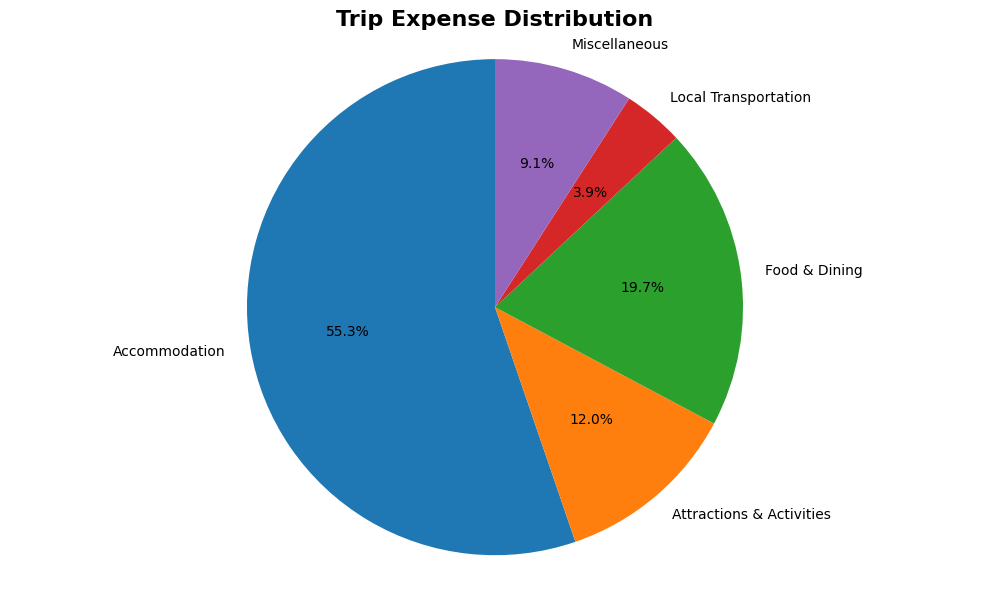

📊 Expense chart saved as 'expense_chart.png'


In [30]:
import matplotlib.pyplot as plt

def visualize_expenses(expenses_data):
    """Create a pie chart of expenses"""
    if expenses_data and "items" in expenses_data:
        expenses_df = pd.DataFrame(expenses_data["items"])
        # Exclude the TOTAL row
        data = expenses_df[expenses_df['category'] != 'TOTAL'].copy()
        
        plt.figure(figsize=(10, 6))
        plt.pie(data['amount'], labels=data['category'], autopct='%1.1f%%', startangle=90)
        plt.title('Trip Expense Distribution', fontsize=16, fontweight='bold')
        plt.axis('equal')
        plt.tight_layout()
        plt.savefig('expense_chart.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("📊 Expense chart saved as 'expense_chart.png'")
    else:
        print("⚠️ No expense data to visualize")

# Visualize expenses
visualize_expenses(result.get("expenses_data"))